In [2]:

#Setup Kaggle credentials and download dataset

import os
import json

# Create .kaggle directory
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

# Read kaggle.json (make sure you've uploaded it to /content/)
with open("/content/kaggle.json", "r") as f:
    kaggle_credentials = json.load(f)

# Save credentials in ~/.kaggle/kaggle.json
with open(os.path.join(kaggle_dir, "kaggle.json"), "w") as f:
    json.dump(kaggle_credentials, f)

os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)  # Secure permissions

# Download and extract dataset from Kaggle

dataset_folder = "/content/melanoma_dataset"
os.makedirs(dataset_folder, exist_ok=True)

# Download and unzip
!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images -p "{dataset_folder}"
!unzip -q "{dataset_folder}/melanoma-skin-cancer-dataset-of-10000-images.zip" -d "{dataset_folder}"

# Check dataset contents
!ls "{dataset_folder}"


Dataset URL: https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images
License(s): CC0-1.0
  0% 0.00/98.7M [00:00<?, ?B/s]
100% 98.7M/98.7M [00:00<00:00, 1.31GB/s]
melanoma_cancer_dataset  melanoma-skin-cancer-dataset-of-10000-images.zip


In [3]:
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib



In [8]:
def load_data(data_dir):
    features, labels = [], []

    for label, class_name in enumerate(["benign", "malignant"]):
        class_path = os.path.join(data_dir, class_name)

        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img is not None:
                    img = cv2.resize(img, (128, 128))
                    feature_vector = hog(
                        img,
                        pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2),
                        feature_vector=True
                    )
                    features.append(feature_vector)
                    labels.append(label)

    return np.array(features), np.array(labels)


In [10]:
from sklearn.model_selection import train_test_split

# Correct directories
train_dir = os.path.join(dataset_folder, "melanoma_cancer_dataset", "train")
test_dir = os.path.join(dataset_folder, "melanoma_cancer_dataset", "test")

# Load train and test data
X_train_full, y_train_full = load_data(train_dir)
X_test, y_test = load_data(test_dir)

# Create validation split (10% of training)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42, stratify=y_train_full
)

print(f"Train samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print("✅ Data scaling complete!")


Train samples: 8644
Validation samples: 961
Test samples: 1000
✅ Data scaling complete!


In [11]:
# -----------------------
# Train KNN
# -----------------------
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

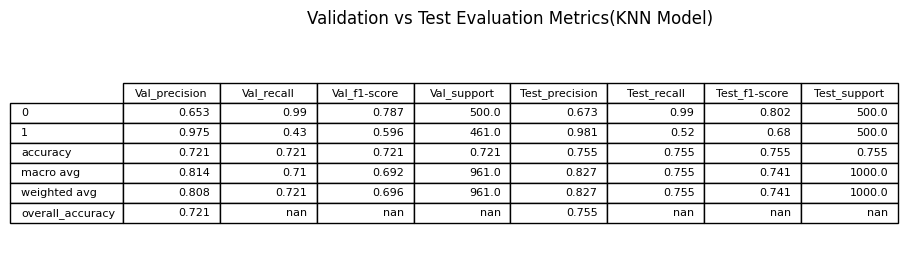

✅ Evaluation results saved as 'evaluation_results.png'


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

# -----------------------
# Evaluate
# -----------------------
y_val_pred = knn_model.predict(X_val)
y_test_pred = knn_model.predict(X_test)

# Compute metrics
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

val_report = classification_report(y_val, y_val_pred, output_dict=True)
test_report = classification_report(y_test, y_test_pred, output_dict=True)

# Convert classification reports to DataFrames
val_df = pd.DataFrame(val_report).transpose()
test_df = pd.DataFrame(test_report).transpose()

# Add accuracy row at the bottom
val_df.loc["overall_accuracy"] = [val_acc, None, None, None]
test_df.loc["overall_accuracy"] = [test_acc, None, None, None]

# Combine both reports side by side
val_df.columns = [f"Val_{col}" for col in val_df.columns]
test_df.columns = [f"Test_{col}" for col in test_df.columns]

combined_df = pd.concat([val_df, test_df], axis=1)

# -----------------------
# Save as table image
# -----------------------
fig, ax = plt.subplots(figsize=(10, len(combined_df) * 0.5))
ax.axis('off')
tbl = ax.table(cellText=combined_df.round(3).values,
               colLabels=combined_df.columns,
               rowLabels=combined_df.index,
               loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.scale(1, 1.2)

plt.title("Validation vs Test Evaluation Metrics(KNN Model)", fontsize=12, pad=10)
plt.savefig("evaluation_results.png", bbox_inches='tight', dpi=300)
plt.show()

print("✅ Evaluation results saved as 'evaluation_results.png'")
